In [15]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd


%matplotlib inline

In [65]:
def reconstitution(data,m,tau):
    """
    %该函数用来重构相空间
    % m为嵌入空间维数
    % tau为时间延迟
    % data为输入时间序列
    % N为时间序列长度
    % X为输出,是m*M维矩阵
    """
    N = len(data)
    M = N-(m-1)*tau  #相空间中点的个数
    X = np.zeros((m,M))
    for j in range(M):
        for i in range(m):
            X[i][j] = data[(i-1)*tau+j]
    return X



In [66]:
def lyapunov_wolf(data,N,m,tau,P):
    """
    %  该函数用来计算时间序列的最大Lyapunov 指数--Wolf 方法
    %  m: 嵌入维数
    %  tau:时间延迟
    %  data:时间序列
    %  N:时间序列长度
    %  P:时间序列的平均周期,选择演化相点距当前点的位置差，即若当前相点为I，则演化相点只能在|I－J|>P的相点中搜寻
    %  lambda_1:返回最大lyapunov指数值
    """
    min_point=1  #要求最少搜索到的点数
    MAX_CISHU=5  #最大增加搜索范围次数
    max_d = 0                                       #最大相点距离
    min_d = 1.0e+100                                #最小相点距离
    avg_dd = 0
    Y=reconstitution(data,m,tau)                  #相空间重构
    M=N-(m-1)*tau                                   #重构相空间中相点的个数
    for i in range(M-1):
        for j in range(i+1,M):
            d = 0
            for k in range(m):
                d = d + (Y[k][i]-Y[k][j])*(Y[k][i]-Y[k][j])
            d = math.sqrt(d)
            if max_d < d :
                max_d = d
            if min_d > d:
                min_d =d
            avg_dd = avg_dd + d
    avg_d = 2*avg_dd/(M*(M-1))                #平均相点距离
    
    dlt_eps = (avg_d - min_d) * 0.02          #若在min_eps～max_eps中找不到演化相点时，对max_eps的放宽幅度
    min_eps = min_d + dlt_eps / 2             #演化相点与当前相点距离的最小限
    max_eps = min_d + 2 * dlt_eps             #演化相点与当前相点距离的最大限
        
   #从P+1～M-1个相点中找与第一个相点最近的相点位置(Loc_DK)及其最短距离DK
    DK = 1.0e+100                            #第i个相点到其最近距离点的距离
    Loc_DK = 1                               #第i个相点对应的最近距离点的下标
    for i in range(P+1,M-1):  #限制短暂分离，从点P+1开始搜索
        d =0 
        for k in range(m):
            d = d + (Y[k][i] -Y[k][0]) *(Y[k][i] - Y[k][0])
        d = math.sqrt(d)
        if (d < DK) and (d > min_eps):
            DK = d
            Loc_DK = i
    #    以下计算各相点对应的李氏数保存到lmd()数组中
    #     i 为相点序号，从1到(M-1)，也是i-1点的演化点；Loc_DK为相点i-1对应最短距离的相点位置，DK为其对应的最短距离
    #     Loc_DK+1为Loc_DK的演化点，DK1为i点到Loc_DK+1点的距离，称为演化距离
    #     前i个log2（DK1/DK）的累计和用于求i点的lambda值
    sum_lmd = 0                             # 存放前i个log2（DK1/DK）的累计和
    lmd = np.zeros(M-1)
    for i in range(1,M-1):                 #计算演化距离      
        DK1 = 0
        for k in range(m):
            DK1 = DK1 + (Y[k][i]-Y[k][Loc_DK+1])*(Y[k][i]-Y[k][Loc_DK+1])
        DK1 = math.sqrt(DK1)
        old_Loc_DK = Loc_DK                # 保存原最近位置相点
        old_DK=DK

        #    计算前i个log2（DK1/DK）的累计和以及保存i点的李氏指数
        if (DK1 != 0)and ( DK != 0):
            sum_lmd = sum_lmd + np.log(DK1/DK) /np.log(2);
        
        lmd[i-1] = sum_lmd/[i] 
        #  以下寻找i点的最短距离：要求距离在指定距离范围内尽量短，与DK1的角度最小
        point_num = 0 #在指定距离范围内找到的候选相点的个数
        cos_sita = 0  #夹角余弦的比较初值 ——要求一定是锐角
        zjfwcs=0     #增加范围次数
        while (point_num == 0):
           # 搜索相点
            for j in range(M-1):
                if abs(j-i) <= (P-1):     #候选点距当前点太近，跳过！
                    continue       
                #计算候选点与当前点的距离
                dnew = 0
                for k in range(m):
                    dnew = dnew + (Y[k][i]-Y[k][j])*(Y[k][i]-Y[k][j])
                dnew = math.sqrt(dnew)
                if (dnew < min_eps) or ( dnew > max_eps):   #不在距离范围，跳过！
                    continue           
                #计算夹角余弦及比较
                DOT = 0
                for k in  range(m):
                    DOT = DOT+(Y[k][i]-Y[k][j])*(Y[k][i]-Y[k][old_Loc_DK+1])
                CTH = DOT/(dnew*DK1)
                #print(CTH)
                if CTH >1.0:
                    CTH = 1.0
                if math.acos(CTH) > (3.14151926/4):      #不是小于45度的角，跳过！
                    continue
                if CTH > cos_sita:   #新夹角小于过去已找到的相点的夹角，保留
                    cos_sita = CTH
                    Loc_DK = j
                    DK = dnew
                point_num = point_num +1
                
            if point_num <= min_point:
                max_eps = max_eps + dlt_eps
                zjfwcs =zjfwcs +1
                if zjfwcs > MAX_CISHU:   #超过最大放宽次数，改找最近的点
                    DK = 1.0e+100
                    for ii in range(M-1):
                        if abs(i-ii) <= (P-1):      #候选点距当前点太近，跳过！
                            continue   
                        d = 0
                        for k in range(m):
                            d = d + (Y[k][i]-Y[k][ii])*(Y[k][i]-Y[k][ii])
                        d = math.sqrt(d)
                        if (d < DK) and  (d > min_eps):
                            DK = d
                            Loc_DK = ii
                    break
                point_num = 0          #     %&&扩大距离范围后重新搜索
                cos_sita = 0
    #取平均得到最大李雅普诺夫指数
    plt.plot(lmd)
    plt.show()
    lambda_1=sum(lmd)/len(lmd)
    return lambda_1


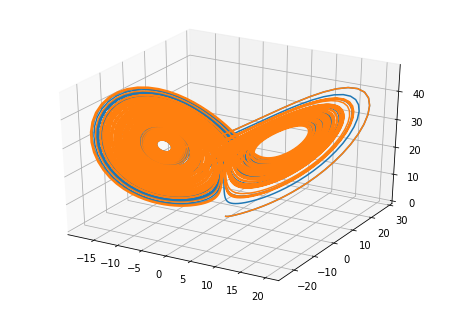

In [19]:
#洛仑兹吸引子代码如下
from scipy.integrate import odeint
import numpy as np
def lorenz(w, t, p, r, b):
# 给出位置矢量w，和三个参数p, r, b计算出
# dx/dt, dy/dt, dz/dt的值
    x, y, z = w
# 直接与lorenz的计算公式对应
    return np.array([p*(y-x), x*(r-z)-y, x*y-b*z])

t = np.arange(0, 80, 0.01) # 创建时间点
# 调用ode对lorenz进行求解, 用两个不同的初始值
track1 = odeint(lorenz, (0.0, 1.00, 0.0), t, args=(10.0, 28.0, 8./3.0))
track2 = odeint(lorenz, (0.0, 1.01, 0.0), t, args=(10.0, 28.0, 8./3.0))
# 绘图
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
ax.plot(track1[:,0], track1[:,1], track1[:,2])
ax.plot(track2[:,0], track2[:,1], track2[:,2])
plt.show()

In [56]:
X = track1[:3000,0]


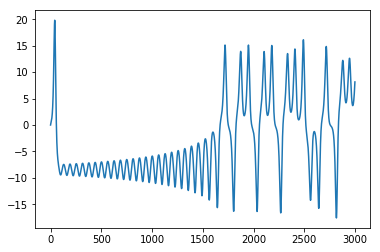

In [57]:
plt.plot(X)


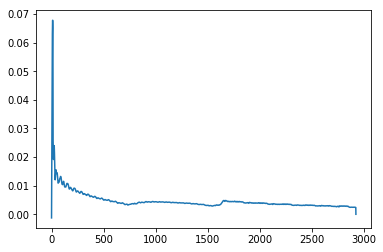

In [58]:
m = 6
tau = 15
data  = X 
N = len(data)
P = 10
lambda_1 = lyapunov_wolf(data,N,m,tau,P)

In [59]:
lambda_1

0.00474539907019445

# C_C 算法

In [80]:
def disjoint(data,t):
    """
    %将时间序列划分为t个不相交的序列
    % data: 输入时间序列
    % t 
    %返回 t x N_t 矩阵
    """
    N = len(data)
    N_t= math.floor(N/t)
    data_d = np.zeros((t,N_t))
    for i in range(t):
        for j in range(N_t):
            data_d[i][j] = data[i+j*t]
    return data_d

In [84]:
def correlation_integral(Y,M,r):
    """
    %计算关联积分
    %Y 为重构的相空间
    %M为想空间中点的个数
    %r为搜索半径
    
    """
    C = 0
    for i in range(M-1):
        for j in range(i+1,M):
            d1 = np.linalg.norm(Y[:,i]-Y[:,j],np.inf) #计算空间中每2点之间的距离，取无穷范数
            if r > d1:
                C +=1
    C = 2*C/(M*(M-1))
    return C

In [119]:
def C_CMethod(data,max_d):
    """
    % 本函数用于求延迟时间tau和时间窗口tw
    % data：输入时间序列
    % max_d：最大时间延迟
    % Smean，Sdeltmean,Scor为返回值
    % tau：计算得到的延迟时间
    % tw：时间窗口
    """
    N = len(data) #时间序列的长度
    Smean = np.zeros(max_d)    #初始化向量
    Sdeltmean = np.zeros( max_d)
    Scor = np.zeros(max_d)
    sigma = np.std(data)  #计算序列的标准差
    # 计算Smean,Sdeltmean,Scor
    for t in range(1, max_d+1):
        S = np.zeros((4, 4))
        Sdelt = np.zeros(4)
        for m in range(2, 6):
            for j in range(1, 5): # r 从sigma/2 到 2*sigma 变化
                r = sigma*j/2
                Xdt = disjoint(data,t)        # 将时间序列data分解成t个不相交的时间序列
                s=0
                for tau in range(1,t+1):
                    N_t = math.floor(N/t)                       # 分成的子序列长度
                    Y = Xdt[tau-1]                         #每个子序列           
                
                    #%计算C(1,N/t,r,t),相当于调用Cs1(tau)=correlation_integral1(Y,r)            
                    Cs1 = 0 
                    for ii in range(N_t-1):
                        for jj in range(ii+1, N_t):
                            d1 = abs(Y[ii]-Y[jj])   #计算状态空间中每两点之间的距离,取无穷范数
                            if r > d1:
                                Cs1 += 1          
                   
                    Cs1=2*Cs1/(N_t*(N_t-1))
              
                    Z = reconstitution(Y,m,1)          # 相空间重构
                    M = N_t-(m-1) # 
                    Cs= correlation_integral(Z,M,r) # 计算C(m,N/t,r,t)
                    s += Cs-pow(Cs1,m)       # 对t个不相关的时间序列求和
                         
                S[m-2][j-1] = s/tau      
       
            Sdelt[m-2]=np.max(S[m-2])- np.min(S[m-2])         #差量计算

        Smean[t]= np.mean(np.mean(S))                          # 计算平均值
        Sdeltmean[t]=np.mean(Sdelt)                         # 计算平均值
        Scor[t]=abs(Smean[t])+Sdeltmean[t]
    return Sdeltmean,Scor


In [ ]:
Sdeltmean,Scor = C_CMethod(data,200)


array([0.        , 0.09512285, 0.18277467, ..., 7.34031245, 7.73662305,
       8.15078546])

In [107]:
S = np.zeros((4, 4))


In [115]:
np.max(S[0,:])


0.0